In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import copy
import seaborn as sns
matplotlib.rcParams.update({'font.size': 22})
import numpy as np

# AF Subtraction R0 vs R8Q Analysis Steps

1 - use "good" markers, (based on visual estimation of staining; low background markers), threshold to get positive cells, define 5 cell types

2 - visualize histograms of single cell intensity distribution after AF subtraction of R0 or R8Q, of each marker, in each cell type 


## Loading Data


In [2]:
#set location of files
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies'

In [3]:
# define samples to work with
ls_sample = ['BC44290-146'] 
s_dapi = 'DAPI8_Nuclei'
dapi_thresh = 1000
d_factor={'c1':10,'c2':30,'c3':200,'c4':500,'c5':500}

## Load Mean Intensity

In [4]:
df_mi_exp = pd.DataFrame()

for s_sample in ls_sample:
    print(f'features_{s_sample}_ExpNormalizedMeanIntensity_{s_dapi}{dapi_thresh}.csv')
    df_tt = pd.read_csv(
        f'{codedir}/Data/features_{s_sample}_ExpNormalizedMeanIntensity_{s_dapi}{dapi_thresh}.csv',
        #sep='\t',
        index_col=0
    )
    df_tt.index = [item.replace('scene1c','scene01') for item in df_tt.index]
    df_tt['scene'] = [item.split('_')[1] for item in df_tt.index]
    df_mi_exp = df_mi_exp.append(df_tt)

features_BC44290-146_ExpNormalizedMeanIntensity_DAPI8_Nuclei1000.csv


In [5]:
# AF subtracted images version
df_mi_org = pd.DataFrame()

for s_sample in ls_sample:
    print(f'features_{s_sample}_FilteredMeanIntensity_{s_dapi}{dapi_thresh}.csv')
    df_tt = pd.read_csv(
        f'{codedir}/Data/features_{s_sample}_FilteredMeanIntensity_{s_dapi}{dapi_thresh}.csv',
        index_col=0
    )
    df_tt.index = [item.replace('scene1c','scene01') for item in df_tt.index]
    df_tt['scene'] = [item.split('_')[1] for item in df_tt.index]
    df_mi_org = df_mi_org.append(df_tt)

features_BC44290-146_FilteredMeanIntensity_DAPI8_Nuclei1000.csv


In [6]:
#load metadata
df_t = pd.read_csv(f'{codedir}/Metadata/44290-146/metadata_{s_sample}_RoundsCyclesTable_ExposureTimes.csv',index_col=0)
print(f'metadata_{s_sample}_RoundsCyclesTable_ExposureTimes.csv')

metadata_BC44290-146_RoundsCyclesTable_ExposureTimes.csv


In [7]:
# factor to normalize thresholds
df_t['expnorm'] = df_t.colors.replace(d_factor)
df_t['expfactor'] = df_t.expnorm/df_t.exposure


In [8]:
df_mi = pd.DataFrame()

for s_sample in ls_sample:
    print(f'features_{s_sample}_AFSubtractedMeanIntensityNegativeR8Q_{s_dapi}{dapi_thresh}.csv')
    df_tt = pd.read_csv(
        f'{codedir}/Data/features_{s_sample}_AFSubtractedMeanIntensityNegativeR8Q_{s_dapi}{dapi_thresh}.csv',
        index_col=0
    )
    df_tt.index = [item.replace('scene1c','scene01') for item in df_tt.index]
    df_tt['scene'] = [item.split('_')[1] for item in df_tt.index]
    df_tt['slide'] = [item.split('_')[0] for item in df_tt.index]
    df_tt['slide_scene'] = df_tt.slide + '_' + df_tt.scene
    df_mi = df_mi.append(df_tt)

features_BC44290-146_AFSubtractedMeanIntensityNegativeR8Q_DAPI8_Nuclei1000.csv


In [9]:
df_mi_sub0 = pd.DataFrame()

for s_sample in ls_sample:
    print(f'features_{s_sample}_AFSubtractedMeanIntensityNegativeR0_{s_dapi}{dapi_thresh}.csv')
    df_tt = pd.read_csv(
        f'{codedir}/Data/features_{s_sample}_AFSubtractedMeanIntensityNegativeR0_{s_dapi}{dapi_thresh}.csv',
        index_col=0
    )
    df_tt.index = [item.replace('scene1c','scene01') for item in df_tt.index]
    df_tt['scene'] = [item.split('_')[1] for item in df_tt.index]
    df_mi_sub0 = df_mi_sub0.append(df_tt)

features_BC44290-146_AFSubtractedMeanIntensityNegativeR0_DAPI8_Nuclei1000.csv


In [10]:
#load positve - df_pos may be a different dataset- just use thresholds directly on R8Q sub
df_pos_new = pd.read_csv(f'{codedir}/Data/20200514_44290_SMT101-Bx2_JE-TMA-41_ManualPositive.csv',index_col=0)

#thresholds not working - use quantile
se_quantile = (df_pos_new[df_pos_new.index.str.contains('BC44290')].sum()/len(df_pos_new[df_pos_new.index.str.contains('BC44290')])).sort_values()
se_quantile = se_quantile.drop(['DAPI_X','DAPI_Y'])

df_pos= pd.DataFrame()
df_pos0 = pd.DataFrame()
for s_marker_loc in se_quantile.index:
    i_thresh = np.quantile(df_mi.loc[:,s_marker_loc],1 - se_quantile.loc[s_marker_loc])
    df_pos[s_marker_loc] = df_mi.loc[:,s_marker_loc] > i_thresh
    df_t.loc[s_marker_loc.split('_')[0],'R8Qthresh'] = i_thresh
    df_pos0[s_marker_loc] = df_mi_sub0.loc[:,s_marker_loc] > i_thresh

In [13]:
#cell types

#define tumor and immune cell types
ls_tumor = ['CK19_Ring','Ecad_Ring'] #avoid 488 channel
ls_exclude = ['CD31_Ring','CD68_Ring','CD3_Ring'] # cd45 had nuclear bg
df_pos['all-tumor'] = df_pos.loc[:,ls_tumor].sum(axis=1)>=1 
df_pos['not-tumor'] = df_pos.loc[:,ls_exclude].sum(axis=1)>=1
df_pos['not-tumor-not-Tcell'] = df_pos.loc[:,['CD31_Ring','CD68_Ring',]].sum(axis=1)>=1
df_pos['Tumor'] = (df_pos.loc[:,'all-tumor'].astype(int) -  df_pos.loc[:,'not-tumor'].astype(int))==1
df_pos['Endothelial'] = df_pos.loc[:,'CD31_Ring']

df_pos['Macrophage'] = (df_pos.loc[:,'CD68_Ring'].astype(int) - df_pos.loc[:,'CD31_Ring'].astype(int)) == 1


df_pos['T-cell'] = (df_pos.loc[:,'CD3_Ring'].astype(int) -  df_pos.loc[:,'not-tumor-not-Tcell'].astype(int))==1
#df_pos['OtherImmune'] = (df_pos.loc[:,'CD45_Ring'].astype(int) - 
df_pos['Other'] = (df_pos.loc[:,['Tumor','T-cell','Macrophage','Endothelial']].sum(axis=1) ==0)
df_pos = df_pos.drop(['all-tumor','not-tumor','not-tumor-not-Tcell'],axis=1)

#five compartments
print(df_pos.loc[:,['Tumor','T-cell','Macrophage','Endothelial','Other']].sum().sum())
print(len(df_pos))
df_pos.loc[:,['Tumor','T-cell','Macrophage','Endothelial','Other']].sum()

24367
24367


Tumor           3559
T-cell         10116
Macrophage      3842
Endothelial     1313
Other           5537
dtype: int64

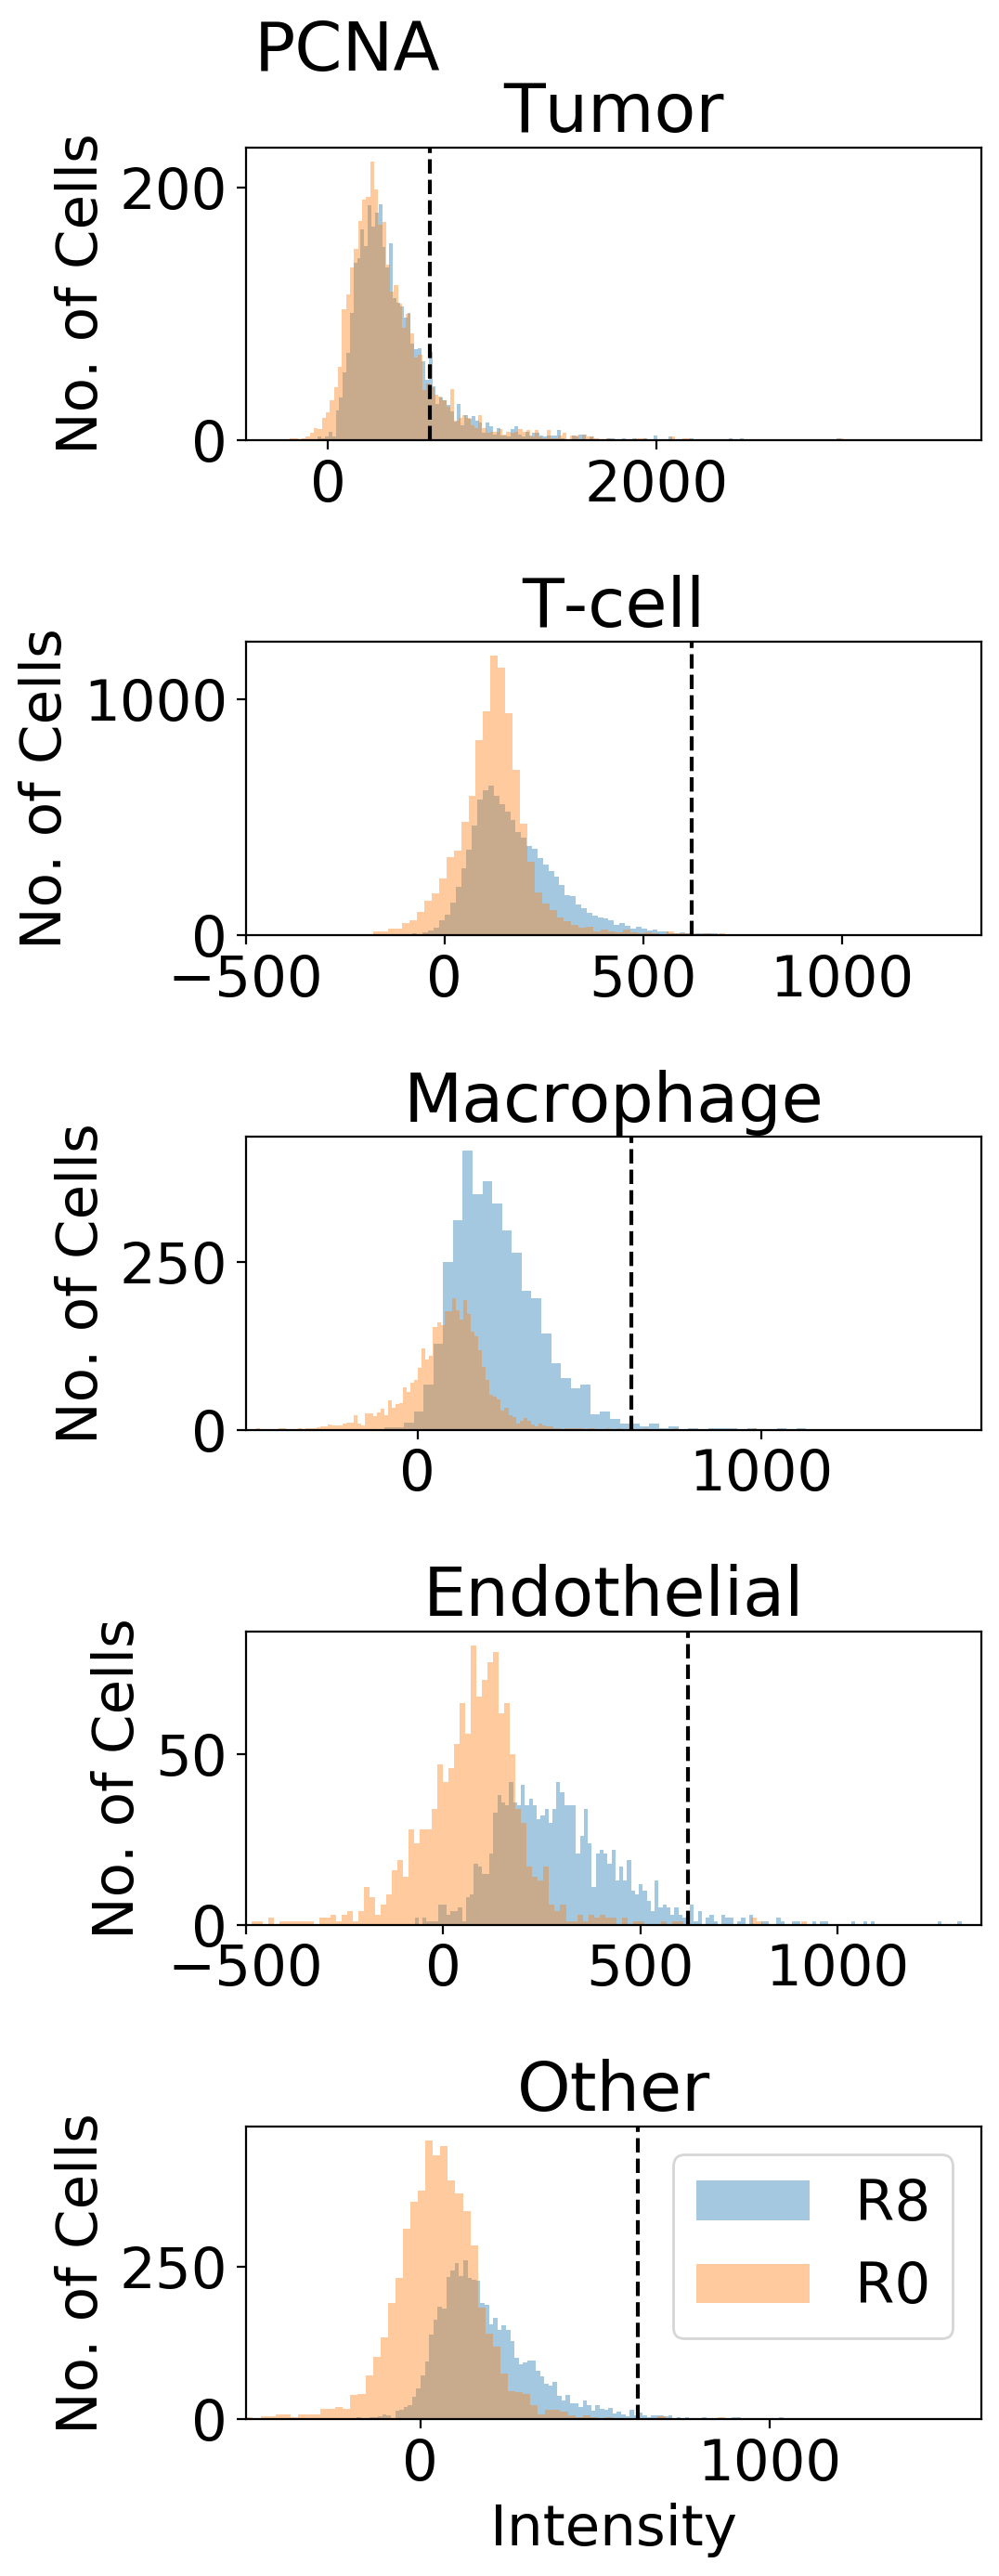

In [15]:
#histograms
ls_luminal = (df_t[(df_t.colors!='c5') & (~df_t.location.isna())]).index + '_' + (df_t[(df_t.colors!='c5') & (~df_t.location.isna())]).location
for s_luminal in ls_luminal:
    #plot subtracted R0 vs R0
    fig,ax = plt.subplots(5,1,figsize=(6,14),dpi=200)
    ax=ax.ravel()
    for idx, s_cell in enumerate(['Tumor','T-cell','Macrophage','Endothelial','Other']):
        ls_cell_index = df_pos[(df_pos.loc[:,s_cell]) & (df_pos.index.str.contains('BC44290-146'))].index
        se_subtracted = df_mi.loc[ls_cell_index,s_luminal]
        i_max = np.quantile(se_subtracted,.999)
        se_subtracted.name = f"{s_luminal.split('_')[0]}_R8Q"
        se_subtracted0 = df_mi_sub0.loc[ls_cell_index,s_luminal]
        sns.distplot(se_subtracted,bins=250,ax=ax[idx],kde=False,label='R8',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_subtracted0,bins=250,ax=ax[idx],kde=False,label='R0',hist_kws=dict(alpha=0.4))
        ax[idx].set_xlabel('')  
        ax[idx].set_title(s_cell)
        ax[idx].set_ylabel('No. of Cells')
        ax[idx].axvline(df_t.loc[s_luminal.split('_')[0],'R8Qthresh'],ymin=0,ymax=1,color='black',linestyle='--')
        ax[idx].set_xlim(-500,i_max)
    ax[idx].legend()  
    ax[idx].set_xlabel(f'Intensity')

    plt.suptitle(s_luminal.split('_')[0],x=.35,y=1)
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/44290-146/R8QvsR0_44290_{s_luminal}_dist.png')
    if s_luminal != 'PCNA_Nuclei':
        plt.close(fig)